In [6]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#### Importing the matches data, removing duplicates and irrelavant columns

In [8]:
matches = pd.read_csv("charting-m-matches.csv", engine = 'python',error_bad_lines=False)
matches = matches.rename(columns={"ï»¿match_id": "match_id"})

matches = matches.drop(columns=['Charted by', 'Umpire', 'Gender', 'Court']) # removing columns that are not required for prediction
matches.drop_duplicates(subset ="match_id", keep="first",inplace=True) # making sure that there are no duplicates

matches.head()

Skipping line 955: field larger than field limit (131072)


,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Date,Tournament,Round,Time,Surface,Best of,Final TB?
0,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,Ernests Gulbis,Mohamed Safwat,R,R,20200307,Davis Cup WG II,RR,NaN,Hard,3,1
1,20200307-M-Davis_Cup_Qualifiers-RR-Alexander_B...,Alexander Bublik,Robin Haase,R,R,20200307,Davis Cup Qualifiers,RR,NaN,Hard,3,1
2,20200306-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-K...,Ernests Gulbis,Karim Mohamed Maamoun,R,R,20200306,Davis Cup WG II,RR,NaN,Hard,3,1
3,20200306-M-Davis_Cup_Qualifiers-RR-Mikhail_Kuk...,Mikhail Kukushkin,Robin Haase,R,R,20200306,Davis Cup Qualifiers,RR,14:10,Hard,3,1
4,20200306-M-Davis_Cup_Qualifiers-RR-Alexander_B...,Alexander Bublik,Tallon Griekspoor,R,R,20200306,Davis Cup Qualifiers,RR,17:10,Hard,3,1


#### Pre-processing the matches data

In [9]:
# Extracting year, month and day from Date column

matches['year'] = np.nan
matches['month'] = np.nan
matches['day'] = np.nan
for i in range(len(matches)):
    data = str(matches.iloc[i, 5])
    matches.iloc[i, 12] = data[0:4]
    matches.iloc[i, 13] = data[4:6]
    matches.iloc[i, 14] = data[6:8]

matches = matches.drop(columns=['Date', 'Time'])
matches

,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Tournament,Round,Surface,Best of,Final TB?,year,month,day
0,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,Ernests Gulbis,Mohamed Safwat,R,R,Davis Cup WG II,RR,Hard,3,1,2020,03,07
1,20200307-M-Davis_Cup_Qualifiers-RR-Alexander_B...,Alexander Bublik,Robin Haase,R,R,Davis Cup Qualifiers,RR,Hard,3,1,2020,03,07
2,20200306-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-K...,Ernests Gulbis,Karim Mohamed Maamoun,R,R,Davis Cup WG II,RR,Hard,3,1,2020,03,06
3,20200306-M-Davis_Cup_Qualifiers-RR-Mikhail_Kuk...,Mikhail Kukushkin,Robin Haase,R,R,Davis Cup Qualifiers,RR,Hard,3,1,2020,03,06
4,20200306-M-Davis_Cup_Qualifiers-RR-Alexander_B...,Alexander Bublik,Tallon Griekspoor,R,R,Davis Cup Qualifiers,RR,Hard,3,1,2020,03,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,19780125-M-Pepsi_Grand_Slam-SF-Brian_Gottfried...,Brian Gottfried,Bjorn Borg,R,R,Pepsi Grand Slam,SF,Clay,3,1,1978,01,25
1701,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,Bjorn Borg,Jiri Hrebec,R,R,Davis Cup World Group F,RR,Hard,3,1,1975,12,19
1702,19750101-M-Australian_Open-F-Jimmy_Connors-Joh...,Jimmy Connors,John Newcombe,L,R,Australian Open,F,Grass,5,0,1975,01,01
1703,19740714-M-Bastad-F-Bjorn_Borg-Adriano_Panatta,Bjorn Borg,Adriano Panatta,R,R,Bastad,F,Clay,5,0,1974,07,14


In [10]:
# Removing spaves from player1 and player2 hand columns

matches.loc[(matches['Pl 2 hand'] == "R "), 'Pl 2 hand'] = "R"
matches.loc[(matches['Pl 1 hand'] == "L "), 'Pl 1 hand'] = "L"
matches.loc[(matches['Pl 1 hand'] == "R "), 'Pl 1 hand'] = "R"

In [11]:
matches.loc[(matches['Surface'].isna()), 'Surface'] = "mis" # Filling null values

In [12]:
matches.describe(include='all')

,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Tournament,Round,Surface,Best of,Final TB?,year,month,day
count,1701,1700,1701,1701,1701,1701,1701,1701,1701.000000,1701,1701,1701,1701
unique,1701,342,322,2,2,192,12,7,NaN,7,37,13,31
top,20170724-M-Bastad-F-Alexandr_Dolgopolov-David_...,Roger Federer,Stefan Edberg,R,R,Australian Open,F,Hard,NaN,1,2019,01,08
freq,1,156,80,1482,1507,152,455,1053,NaN,1283,517,211,82
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.790123,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978015,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


#### Importing the points data, removing irrelavant columns

In [13]:
points = pd.read_csv("C:/4th_sem/MS_Project/Data/charting-m-points.csv", delimiter=',', encoding='utf8', low_memory=False)
points = points.drop(columns=['TBpt', 'Ret', 'Serving', '1st', '2nd', 'Notes', '1stSV', '2ndSV', '1stIn', '2ndIn', 'Rally', 'rallyLen', 
                              'PtsAfter', 'Gm1.1', 'Gm2.1', 'Set1.1', 'Set2.1']) # removing columns that are redundant from points.csv

#### Pre-processing the points data

In [14]:
# Extarcting game number from 'Gm#' column
new = points["Gm#"].str.split(" ", n = 1, expand = True)
points["Gm#"] = new[0]

In [15]:
# Splitting 'Pts' column to Player 1 points and Player 2 points 
points = points.rename(columns={"Pts": "PtsBefore_P1"})

new1 = points["PtsBefore_P1"].str.split("-", n = 1, expand = True)
pts_p1 = []
pts_p2 = []
deuce =[]
prev_gm = 0
flag = 0

for i in range(len(points)):    
    if points.iloc[i, 10] == 1:
        pts_p1.append(new1.iloc[i, 0])
        pts_p2.append(new1.iloc[i, 1])
    elif points.iloc[i, 10] == 2:
        pts_p1.append(new1.iloc[i, 1])
        pts_p2.append(new1.iloc[i, 0])
    
    curr_gm = points.iloc[i, 7]
    if prev_gm == curr_gm:
        flag = 1 - flag
        deuce.append(flag)
    else:
        flag = 1
        deuce.append(flag)
    
    prev_gm = curr_gm

points["PtsBefore_P1"] = pts_p1
points["PtsBefore_P2"] = pts_p2
points["is_deuce_side?"] = deuce

# Removing the points, that are noted in incorrect formated, from player 1 points
points.loc[(points['PtsBefore_P1'].isin(['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2', '3', '4', '5', '6', 
                                         '7', '8', '9', 'Apr', 'Feb', 'Jan', 'Jun', 'Mar', 'May', 'Jul', 'Aug', 'Sep', 
                                         'Oct', 'Nov', 'Dec'])), 'PtsBefore_P1'] = "mis"
points.loc[(points['PtsBefore_P1'] == "00"), 'PtsBefore_P1'] = "0"

# Removing the points, that are noted in incorrect formated, from player 2 points 
points.loc[(points['PtsBefore_P2'].isin(['1', '12', '13', '14', '16', '17', '18', '2', '3', '4', '5', '6', '7', '9', '8', '11', '10', 'Apr', 'Aug', 
                                         'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'])), 'PtsBefore_P2'] = "mis"

points.loc[(points['PtsBefore_P2'] == "00"), 'PtsBefore_P2'] = "0"

In [16]:
#points.columns.get_loc("rallyCount")

In [17]:
# Converitng the future columns(like 'PtWinner', 'GmW' which denote the situation after the match) to represent situation 
#before the match by shifting them one position downwards for every match 

match = points.groupby(['match_id'], as_index=False,sort=False).count()
num_matches = len(points['match_id'].unique())
start = 0

for col in [11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]:
    start = 0
    for i in range(num_matches):
        end = start + match.iloc[i, 1] - 1
        PtWinner = points.iloc[start:end, col].tolist()
        points.iloc[start:end+1, col] = [0] + PtWinner
        start = match.iloc[i, 1]

In [18]:
# Calculating the shots played till now, in a match, to estimate player's fatigue

shots_played_till_now = []
prev_match = points.iloc[0, 0]
s = 0

for i in range(len(points)):
    curr_match = points.iloc[i, 0]
    
    if prev_match == curr_match:
        s = s + points.iloc[i, 25]
    else:
        s = 0   
    
    shots_played_till_now.append(s)
    
    prev_match == curr_match

points["shots_played_till_now"] = shots_played_till_now

In [19]:
# renaming and rearranging the columns for easy understanding

points = points.rename(columns={"Pt": "pointNumber", "Gm#": "gameNumber", "Set1": "num_sets_won_P1", "Set2": "num_sets_won_P2", 
                                 "Gm1": "num_games_won_P1", "Gm2": "num_games_won_P2", "Svr":"server", "PtWinner": "prev_pt_winner", 
                                "isSvrWinner": "is_prev_pt_won_by_server", "GmW": "prev_game_winner", "SetW": "prev_set_winner", 
                                "rallyCount": "prev_rallyCount", "Sv1":"serve1", "Sv2":"serve2"})
cols = ['match_id', 'pointNumber', 'gameNumber', 'num_sets_won_P1', 'num_sets_won_P2', 'num_games_won_P1', 'num_games_won_P2', 
        'PtsBefore_P1', 'PtsBefore_P2', 'shots_played_till_now', 'TbSet', 'TB?', 'is_deuce_side?', 'server', 'isRally1st', 'isRally2nd', 
        'isAce', 'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble', 'prev_pt_winner', 'is_prev_pt_won_by_server', 
        'prev_game_winner', 'prev_set_winner', 'prev_rallyCount', 'serve1', 'serve2']
points = points[cols]

In [21]:
temp = points
temp = temp.astype({'gameNumber': 'int', 'PtsBefore_P1': 'category', 'PtsBefore_P1': 'category', 'PtsBefore_P2': 'category', 
                    'TbSet': 'category', 'TB?':'category', 'is_deuce_side?':'category', 'isRally1st':'category', 
                    'isRally2nd':'category', 'isAce':'category', 'isUnret':'category', 'isRallyWinner':'category', 'isForced':'category', 
                    'isUnforced':'category', 'isDouble':'category', 'prev_pt_winner': 'category', 'is_prev_pt_won_by_server': 'category', 
                    'prev_game_winner': 'category', 'prev_set_winner': 'category', 'serve1': 'category', 'serve2': 'category'})

In [ ]:
#temp.describe(exclude='number')

#### Merging matches.csv and points.csv on 'match_id' column

In [135]:
data = pd.merge(matches, points, on='match_id', how='inner')

In [136]:
data = data.loc[(data['Player 1'] == 'Roger Federer') | (data['Player 2'] == 'Roger Federer')] # filtering federer's matches

#### Pre-processing the combined data

In [137]:
# Making server column zero when federer is not serving and one when federer is serving
data.loc[((data['Player 1'] == 'Roger Federer') & (data['server'] == 2)), 'server'] = 0
data.loc[((data['Player 2'] == 'Roger Federer') & (data['server'] == 1)), 'server'] = 0
data.loc[((data['Player 2'] == 'Roger Federer') & (data['server'] == 2)), 'server'] = 1

data = data.rename(columns={"server": "is_federer_server"})

In [138]:
# Changing 'Player 1 and Player 2' to 'Federed and Opponent'
data.loc[(data['Player 2'] == 'Roger Federer'), 'Player 2'] = data.loc[(data['Player 2'] == 'Roger Federer'), 'Player 1']
data['Player 1'] = "Roger Federer"

# Changing 'Pl 1 hand and Pl 2 hand' to 'Federed hand and Opponent hand'
data.loc[(data['Player 2'] == 'Roger Federer'), 'Pl 2 hand'] = data.loc[(data['Player 2'] == 'Roger Federer'), 'Pl 1 hand']
data['Pl 1 hand'] = "R"

data = data.rename(columns={"Player 2": "Opponent","Pl 2 hand": "Opponent hand"})

#### Calculating the percent of serves on deuce and ad sides, on various surfaces and tournaments

In [139]:
# Surface = hard or tournament = US Open

#data1 = data[(data['Surface'] == 'Hard') | (data['Tournament'] == 'US Open')]
#serve1_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1)])/len(data1))*100
#serve1_ad_side = (len(data1[(data1['is_deuce_side?'] == 0)])/len(data1))*100

#serve2_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
#serve2_ad_side = (len(data1[(data1['is_deuce_side?'] == 0) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100

In [140]:
# Surface = grass or tournament = Wimbledon

#data1 = data[(data['Surface'] == 'Grass') | (data['Tournament'] == 'Wimbledon')]
#serve1_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1)])/len(data1))*100
#serve1_ad_side = (len(data1[(data1['is_deuce_side?'] == 0)])/len(data1))*100

#serve2_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
#serve2_ad_side = (len(data1[(data1['is_deuce_side?'] == 0) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100

In [141]:
# Surface = Clay or tournament = Roland Garros(French Open)

#data1 = data[(data['Surface'] == 'Clay') | (data['Tournament'] == 'Roland Garros')]
#serve1_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1)])/len(data1))*100
#serve1_ad_side = (len(data1[(data1['is_deuce_side?'] == 0)])/len(data1))*100

#serve2_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
#serve2_ad_side = (len(data1[(data1['is_deuce_side?'] == 0) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100

In [142]:
#for court in data['Surface'].unique():
#    data1 = data[(data['Surface'] == court)]
#    serve1_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1)])/len(data1))*100
#    serve1_ad_side = (len(data1[(data1['is_deuce_side?'] == 0)])/len(data1))*100

#    serve2_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
#    serve2_ad_side = (len(data1[(data1['is_deuce_side?'] == 0) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
    
#    print("\nSurface: " + court)
#    print("\nFirst serve, Deuce side:  " + str(serve1_deuce_side) + "\nSecond serve, Deuce side: " + str(serve2_deuce_side) + 
#          "\nFirst serve, Ad side:     " + str(serve1_ad_side)+ "\nSecond serve, Ad side:    " + str(serve2_ad_side))

In [143]:
#for tournament in ['US Open', 'Wimbledon', 'Roland Garros', 'Australian Open', 'Olympics']:
#    data1 = data[data['Tournament'] == tournament]
#    serve1_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1)])/len(data1))*100
#    serve1_ad_side = (len(data1[(data1['is_deuce_side?'] == 0)])/len(data1))*100

#    serve2_deuce_side = (len(data1[(data1['is_deuce_side?'] == 1) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
#    serve2_ad_side = (len(data1[(data1['is_deuce_side?'] == 0) & (data1['serve2'].isna())])/len(data1[data1['serve2'].isna()]))*100
    
#    print("\nTournament: " + tournament)
#    print("\nFirst serve, Deuce side:  " + str(serve1_deuce_side) + "\nSecond serve, Deuce side: " + str(serve2_deuce_side) + 
#          "\nFirst serve, Ad side:     " + str(serve1_ad_side)+ "\nSecond serve, Ad side:    " + str(serve2_ad_side))

#### Pre-processing the combined data

In [144]:
#Selecting rows where federer is serving
data = data[data['is_federer_server'] == 1].drop(columns=['match_id', 'Player 1', 'Pl 1 hand'])

In [145]:
# Removing symbols representing the aces, unreturnables, forced/unforced errors
data['serve1'] = data['serve1'].map(lambda x: x.rstrip('*#@;'))

In [146]:
# Splitting serve1 to serve direction and error
new1 = data["serve1"].str.split("", n = 3, expand = True)
data['serve1_direction'] = new1[1]
data['serve1_error'] = new1[2]

In [147]:
# Splitting serve2 to serve direction and error
new2 = data["serve2"].str.split("", n = 3, expand = True)
data['serve2_direction'] = new2[1]
data['serve2_error'] = new2[2]

In [148]:
# Removing incorrect symbols serve1_direction column and replacing them with 'O' means unknown direction
data.loc[(data['serve1_direction'] == 'e'), 'serve1_error'] = 'e'
data.loc[(data['serve1_direction'].isin(['P', 'S', 'R', 's', '3', 'e'])), 'serve1_direction'] = '0'

In [149]:
# Capturing serve and volley attempt information
data['is_serve-and-volley_attempt'] = 0
data.loc[(data['serve1_error'] == '+'), 'is_serve-and-volley_attempt'] = 1

In [150]:
# Replacing incorrect symbols serve1_error column with 'e' means unknown fault
data.loc[(data['serve1_error'].isin(['+', 's', 'f'])), 'serve1_error'] = 'e'

In [151]:
data['temp'] = new1[3]
data.loc[((data['serve1_error'] == 'e') & (data['temp'].isin(['d', 'n', 'w', 'x']))), 'serve1_error'] = data.loc[((data['serve1_error'] == 'e') & (data['temp'].isin(['d', 'n', 'w', 'x']))), 'temp']

In [152]:
# Creating a new category named 'no_fault' to indicate that there is no error
data.loc[(data['serve1_error'] == ''), 'serve1_error'] = "no_fault"

In [153]:
# Creating a new category named 'no_serve' to indicate that there is no second serve
data.loc[(data['serve1_error'] == "no_fault"), 'serve2_direction'] = "no_serve"
data.loc[(data['serve2_direction'] == "no_serve"), 'serve2_error'] = "no_serve"

In [154]:
# Removing incorrect/missing symbols in serve2_direction column and replacing them with 'O' means unknown direction
data.loc[((data['serve2_direction'] == '7') | (data['serve2_direction'].isna())), 'serve2_direction'] = '0'

In [155]:
# Replacing incorrect symbols serve2_error column with 'e' means unknown fault
data.loc[(data['serve2_error'].isin(['*', '#'])), 'serve2_error'] = 'e'

# Creating a new category named 'no_fault' to indicate that there is no error
data.loc[((data['serve2_error']=='')|(data['serve2_error'].isna())), 'serve2_error'] = 'no_fault'

In [156]:
data = data.drop(columns=['temp', 'serve1','serve2'])
data1 = data

#### Encoding the categorical columns to numeric values

In [157]:
data["Opponent"]= data["Opponent"].astype(str)
labelencoder_player = LabelEncoder()
data['Opponent'] = labelencoder_player.fit_transform(data['Opponent'])

In [158]:
data["Opponent hand"] = data["Opponent hand"].astype(str)

labelencoder_hand = LabelEncoder()
data['Opponent hand'] = labelencoder_hand.fit_transform(data['Opponent hand'])

In [159]:
data["Tournament"]= data["Tournament"].astype(str)
labelencoder_tournament = LabelEncoder()
data['Tournament'] = labelencoder_tournament.fit_transform(data['Tournament'])

data["Round"]= data["Round"].astype(str)
labelencoder_round = LabelEncoder()
data['Round'] = labelencoder_round.fit_transform(data['Round'])

In [160]:
data["Surface"]= data["Surface"].astype(str)
labelencoder_surface = LabelEncoder()
data['Surface'] = labelencoder_surface.fit_transform(data['Surface'])

data["Final TB?"]= data["Final TB?"].astype(str)
labelencoder_FinalTB = LabelEncoder()
data['Final TB?'] = labelencoder_FinalTB.fit_transform(data['Final TB?'])

In [161]:
labelencoder_pts = LabelEncoder()
labelencoder_pts.fit(data['PtsBefore_P1'])
data['PtsBefore_P1'] = labelencoder_pts.transform(data['PtsBefore_P1'])
data['PtsBefore_P2'] = labelencoder_pts.transform(data['PtsBefore_P2'])

In [162]:
labelencoder_TbSet = LabelEncoder()
data['TbSet'] = labelencoder_TbSet.fit_transform(data['TbSet'])

labelencoder_TB = LabelEncoder()
data['TB?'] = labelencoder_TB.fit_transform(data['TB?'])

In [163]:
# Encoding serve directions
data["serve1_direction"]= data["serve1_direction"].astype(str)
data["serve2_direction"]= data["serve2_direction"].astype(str)

labelencoder_serve_direction = LabelEncoder()
labelencoder_serve_direction.fit_transform(data["serve2_direction"].unique())

data['serve1_direction'] = labelencoder_serve_direction.transform(data['serve1_direction'])
data['serve2_direction'] = labelencoder_serve_direction.transform(data['serve2_direction'])

# Encoding serve faults
data["serve1_error"]= data["serve1_error"].astype(str)
data["serve2_error"]= data["serve2_error"].astype(str)

labelencoder_serve_error = LabelEncoder()
labelencoder_serve_error.fit(['no_serve', 'no_fault', 'n', 'd', 'w', 'e', 'x', 'g'])

data['serve1_error'] = labelencoder_serve_error.transform(data['serve1_error'])
data['serve2_error'] = labelencoder_serve_error.transform(data['serve2_error'])

#### Converting columns to appropriate data types

In [164]:
data["Best of"]= data["Best of"].astype(int)
data = data.astype({'Opponent': 'category', 'Opponent hand': 'category', 'Tournament': 'category', 
                    'Round': 'category', 'Surface': 'category', 'Best of': 'category', 'Final TB?': 'category', 'year':'int', 
                    'month':'category', 'day':'category'})

In [165]:
data = data.astype({"prev_pt_winner" : "int", "prev_game_winner" : "int", "prev_set_winner" : "int", "prev_rallyCount" : "int"})

data = data.astype({'gameNumber': 'int', 'PtsBefore_P1': 'category', 'PtsBefore_P1': 'category', 'PtsBefore_P2': 'category', 
                    'TbSet': 'category', 'TB?':'category', 'is_deuce_side?':'category','is_federer_server':'category', 'isRally1st':'category', 
                    'isRally2nd':'category', 'isAce':'category', 'isUnret':'category', 'isRallyWinner':'category', 'isForced':'category', 
                    'isUnforced':'category', 'isDouble':'category', 'prev_pt_winner': 'category', 'is_prev_pt_won_by_server': 'category', 
                    'prev_game_winner': 'category', 'prev_set_winner': 'category', 'serve1_direction': 'category', 
                    'serve1_error': 'category', 'serve2_direction': 'category', 
                    'serve2_error': 'category', 'is_serve-and-volley_attempt': 'category'})

In [166]:
cols = ['Opponent', 'Opponent hand', 'Tournament', 'Round', 'Surface', 'Best of', 'Final TB?', 'year', 'month', 'day',
        'pointNumber', 'gameNumber', 'num_sets_won_P1', 'num_sets_won_P2', 'num_games_won_P1', 'num_games_won_P2', 
        'PtsBefore_P1', 'PtsBefore_P2', 'shots_played_till_now', 'TbSet', 'TB?', 'is_deuce_side?', 'is_federer_server', 'isRally1st', 'isRally2nd', 
        'isAce', 'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble', 'prev_pt_winner', 'is_prev_pt_won_by_server', 
        'prev_game_winner', 'prev_set_winner', 'prev_rallyCount', 'is_serve-and-volley_attempt', 'serve1_direction', 
        'serve1_error', 'serve2_direction', 'serve2_error']
data = data[cols]

In [52]:
#hist = data['Tournament'].hist()

In [53]:
#labelencoder_tournament.classes_

#### Model to predict 'serve1_direction'

In [59]:
# Splitting the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-4], data[['serve1_direction']], test_size=0.3, random_state=0, stratify=data[['serve1_direction']])

In [60]:
# Training decision trees with tree depths(try until log2(number of features)+10 to find the best tree), partition criteria
results = pd.DataFrame(columns=['treeDepth', 'criteria', 'training_accuracy', 'testing_accuracy'])
for depth in range(1, math.ceil(math.log(39, 2)) + 10):
    for criteria in ["entropy", "gini"]:
        model = DecisionTreeClassifier(criterion=criteria, max_depth=depth, random_state=0)
        model = model.fit(X_train, y_train)
        score_test = model.score(X_test, y_test)
        score_train = model.score(X_train, y_train)
        results = results.append({'treeDepth': depth, 'criteria': criteria, 'training_accuracy': score_train, 'testing_accuracy': score_test}, ignore_index=True)

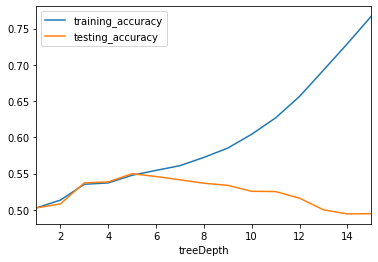

In [63]:
plot_entropy = results.loc[results['criteria'] == "entropy"].plot(x='treeDepth', y=['training_accuracy', 'testing_accuracy'])

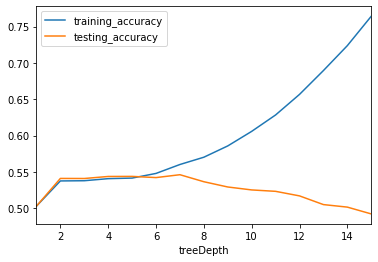

In [62]:
plot_gini = results.loc[results['criteria'] == "gini"].plot(x='treeDepth', y=['training_accuracy', 'testing_accuracy'])

In [64]:
# Training Support vector machines
clf = SVC(kernel='rbf', gamma='scale', probability=False, decision_function_shape = 'ovr', random_state=0)
clf.fit(X_train, y_train.values.ravel())
clf.score(X_test, y_test, sample_weight=None)

0.5027053140096618

In [66]:
# Training random forest with 1000 trees

model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0, n_jobs=-1)
model = model.fit(X_train, y_train.values.ravel())
   
score_test = model.score(X_test, y_test.values.ravel())
score_train = model.score(X_train, y_train.values.ravel())

# Extracting important features
important_features = pd.DataFrame(model.feature_importances_, columns=['importance'])
important_features['features'] = data.drop(columns=['serve1_direction', 'serve1_error', 'serve2_direction', 'serve2_error']).columns
important_features = important_features.sort_values('importance', ascending=False)

print("Test Accuracy: ", score_test, "Training Accuracy: ", score_train) # accuracy of random forest

Test Accuracy:  0.5459903381642512 Training Accuracy:  0.6263613400140793


In [67]:
important_features

,importance,features
10,0.085275,pointNumber
21,0.069779,is_deuce_side?
7,0.064107,year
11,0.063506,gameNumber
0,0.061706,Opponent
9,0.055140,day
35,0.054264,prev_rallyCount
2,0.048197,Tournament
23,0.042575,isRally1st
3,0.038804,Round


#### Model to predict 'serve1_error'

In [74]:
# Splitting the data into test and training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(data.iloc[:,0:-4], data[['serve1_error']], test_size=0.3, random_state=42)

In [75]:
# Training decision trees with tree depths, partition criteria
results1 = pd.DataFrame(columns=['treeDepth', 'criteria', 'training_accuracy', 'testing_accuracy'])
for depth in range(1, math.ceil(math.log(39, 2)) + 10):
    for criteria in ["entropy", "gini"]:
        model = DecisionTreeClassifier(criterion=criteria, max_depth=depth, random_state=0)
        model = model.fit(X_train1, y_train1)
        score_test = model.score(X_test1, y_test1)
        score_train = model.score(X_train1, y_train1)
        results1 = results1.append({'treeDepth': depth, 'criteria': criteria, 'training_accuracy': score_train, 'testing_accuracy': score_test}, ignore_index=True)

In [76]:
results1

,treeDepth,criteria,training_accuracy,testing_accuracy
0,1,entropy,0.744420,0.745314
1,1,gini,0.744420,0.745314
2,2,entropy,0.752412,0.752850
3,2,gini,0.752412,0.752850
4,3,entropy,0.757961,0.757874
5,3,gini,0.755435,0.753720
6,4,entropy,0.758127,0.757488
7,4,gini,0.756346,0.752657
8,5,entropy,0.760280,0.755169
9,5,gini,0.760321,0.747923


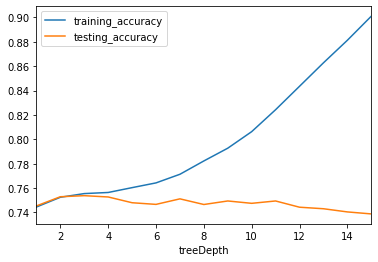

In [77]:
plot_gini = results1.loc[results1['criteria'] == "gini"].plot(x='treeDepth', y=['training_accuracy', 'testing_accuracy'])

In [78]:
# Training Support vector machines
clf1 = SVC(kernel='rbf', gamma='scale', probability=False, decision_function_shape = 'ovr', random_state=0)
clf1.fit(X_train1, y_train1.values.ravel())
clf1.score(X_test1, y_test1, sample_weight=None)

0.6213526570048309

In [80]:
# Training random forest with 1000 trees

model = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=0, n_jobs=-1)
model = model.fit(X_train1, y_train1.values.ravel())
    
score_test = model.score(X_test1, y_test1.values.ravel())
score_train = model.score(X_train1, y_train1.values.ravel())

# Extracting important features
important_features = pd.DataFrame(model.feature_importances_, columns=['importance'])
important_features['features'] = data.drop(columns=['serve1_direction', 'serve1_error', 'serve2_direction', 'serve2_error']).columns
important_features = important_features.sort_values('importance', ascending=False)

print("Test Accuracy: ", score_test, "Training Accuracy: ", score_train) # accuracy of random forest

Test Accuracy:  0.7593236714975845 Training Accuracy:  0.9002443165348462


In [81]:
important_features

,importance,features
24,0.397384,isRally2nd
23,0.284678,isRally1st
35,0.042279,prev_rallyCount
25,0.038487,isAce
29,0.024045,isUnforced
10,0.018121,pointNumber
30,0.017183,isDouble
32,0.014749,is_prev_pt_won_by_server
11,0.012992,gameNumber
0,0.012946,Opponent


#### Model to predict 'serve2_direction'

In [82]:
# Splitting the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-2], data[['serve2_direction']], test_size=0.3, random_state=0, stratify=data[['serve2_direction']])

In [83]:
# Training decision trees with tree depths, partition criteria
results = pd.DataFrame(columns=['treeDepth', 'criteria', 'training_accuracy', 'testing_accuracy'])
for depth in range(1, math.ceil(math.log(39, 2)) + 10):
    for criteria in ["entropy", "gini"]:
        model = DecisionTreeClassifier(criterion=criteria, max_depth=depth, random_state=0)
        model = model.fit(X_train, y_train)
        score_test = model.score(X_test, y_test)
        score_train = model.score(X_train, y_train)
        results = results.append({'treeDepth': depth, 'criteria': criteria, 'training_accuracy': score_train, 'testing_accuracy': score_test}, ignore_index=True)

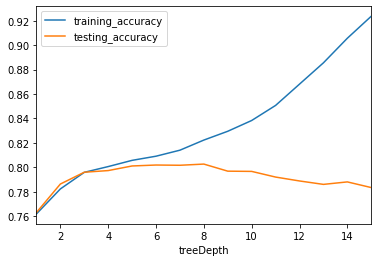

In [84]:
plot_entropy = results.loc[results['criteria'] == "entropy"].plot(x='treeDepth', y=['training_accuracy', 'testing_accuracy'])

In [86]:
results

,treeDepth,criteria,training_accuracy,testing_accuracy
0,1,entropy,0.761812,0.762995
1,1,gini,0.761812,0.762995
2,2,entropy,0.782268,0.786280
3,2,gini,0.782268,0.786280
4,3,entropy,0.795851,0.795942
5,3,gini,0.795851,0.795942
6,4,entropy,0.800571,0.797295
7,4,gini,0.800571,0.797295
8,5,entropy,0.805665,0.801063
9,5,gini,0.805955,0.801063


In [87]:
# Training Support vector machines
clf = SVC(kernel='rbf', gamma='scale', probability=False, decision_function_shape = 'ovr', random_state=0)
clf.fit(X_train, y_train.values.ravel())
clf.score(X_test, y_test, sample_weight=None)

0.6180676328502416

In [88]:
# Training random forest with 1000 trees

model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0, n_jobs=-1)
model = model.fit(X_train, y_train.values.ravel())
   
score_test = model.score(X_test, y_test.values.ravel())
score_train = model.score(X_train, y_train.values.ravel())

# Extracting important features
important_features = pd.DataFrame(model.feature_importances_, columns=['importance'])
important_features['features'] = data.drop(columns=['serve2_direction', 'serve2_error']).columns
important_features = important_features.sort_values('importance', ascending=False)

print("Test Accuracy: ", score_test, "Training Accuracy: ", score_train) # accuracy of random forest

Test Accuracy:  0.8085990338164252 Training Accuracy:  0.8779659613234503


In [89]:
important_features

,importance,features
24,0.347982,isRally2nd
23,0.217643,isRally1st
38,0.209374,serve1_error
35,0.031617,prev_rallyCount
25,0.027736,isAce
29,0.017252,isUnforced
30,0.013436,isDouble
21,0.013187,is_deuce_side?
32,0.011323,is_prev_pt_won_by_server
10,0.008860,pointNumber


#### Model to predict 'serve2_error'

In [94]:
# Splitting the data into test and training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(data.iloc[:,0:-2], data[['serve2_error']], test_size=0.3, random_state=42)

In [95]:
# Training decision trees with tree depths, partition criteria
results1 = pd.DataFrame(columns=['treeDepth', 'criteria', 'training_accuracy', 'testing_accuracy'])
for depth in range(1, math.ceil(math.log(39, 2)) + 10):
    for criteria in ["entropy", "gini"]:
        model = DecisionTreeClassifier(criterion=criteria, max_depth=depth, random_state=0)
        model = model.fit(X_train1, y_train1)
        score_test = model.score(X_test1, y_test1)
        score_train = model.score(X_train1, y_train1)
        results1 = results1.append({'treeDepth': depth, 'criteria': criteria, 'training_accuracy': score_train, 'testing_accuracy': score_test}, ignore_index=True)

In [96]:
results1

,treeDepth,criteria,training_accuracy,testing_accuracy
0,1,entropy,0.970889,0.973913
1,1,gini,0.970889,0.973913
2,2,entropy,0.980496,0.983575
3,2,gini,0.980496,0.983575
4,3,entropy,0.983478,0.986280
5,3,gini,0.983478,0.986280
6,4,entropy,0.988778,0.988502
7,4,gini,0.989151,0.988502
8,5,entropy,0.989316,0.987440
9,5,gini,0.989441,0.988792


In [97]:
# Training Support vector machines
clf1 = SVC(kernel='rbf', gamma='scale', probability=False, decision_function_shape = 'ovr', random_state=0)
clf1.fit(X_train1, y_train1.values.ravel())
clf1.score(X_test1, y_test1, sample_weight=None)

0.6213526570048309

In [98]:
# Training random forest with 1000 trees

model = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=0, n_jobs=-1)
model = model.fit(X_train1, y_train1.values.ravel())
    
score_test = model.score(X_test1, y_test1.values.ravel())
score_train = model.score(X_train1, y_train1.values.ravel())

# Extracting important features
important_features = pd.DataFrame(model.feature_importances_, columns=['importance'])
important_features['features'] = data.drop(columns=['serve2_direction', 'serve2_error']).columns
important_features = important_features.sort_values('importance', ascending=False)

In [99]:
print("Test Accuracy: ", score_test, "Training Accuracy: ", score_train) # accuracy of random forest

Test Accuracy:  0.9888888888888889 Training Accuracy:  0.999213217938631


In [100]:
important_features

,importance,features
24,0.398819,isRally2nd
23,0.230088,isRally1st
38,0.212401,serve1_error
35,0.038597,prev_rallyCount
25,0.027522,isAce
29,0.022100,isUnforced
30,0.019525,isDouble
32,0.009464,is_prev_pt_won_by_server
28,0.005813,isForced
36,0.005742,is_serve-and-volley_attempt
